In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [23]:
import arviz as az
from corner import corner
import gbfit # To have access to waveform tools; this is safe to import as a module
from kde_contour import kdeplot_2d_clevels
import pandas as pd
import scipy.stats as ss
import seaborn as sns
import warnings

sns.set_context('notebook')
sns.set_palette('colorblind')
sns.set_style('ticks')

In [3]:
fit = az.from_netcdf('testinj2.nc')
inj = genfromtxt('testinj2.dat', names=True)

Tobs = fit.constant_data.Tobs.values[0]
hbin = int(round(fit.constant_data.hbin.values[0]))

In [4]:
good_chains = [0,1,2]

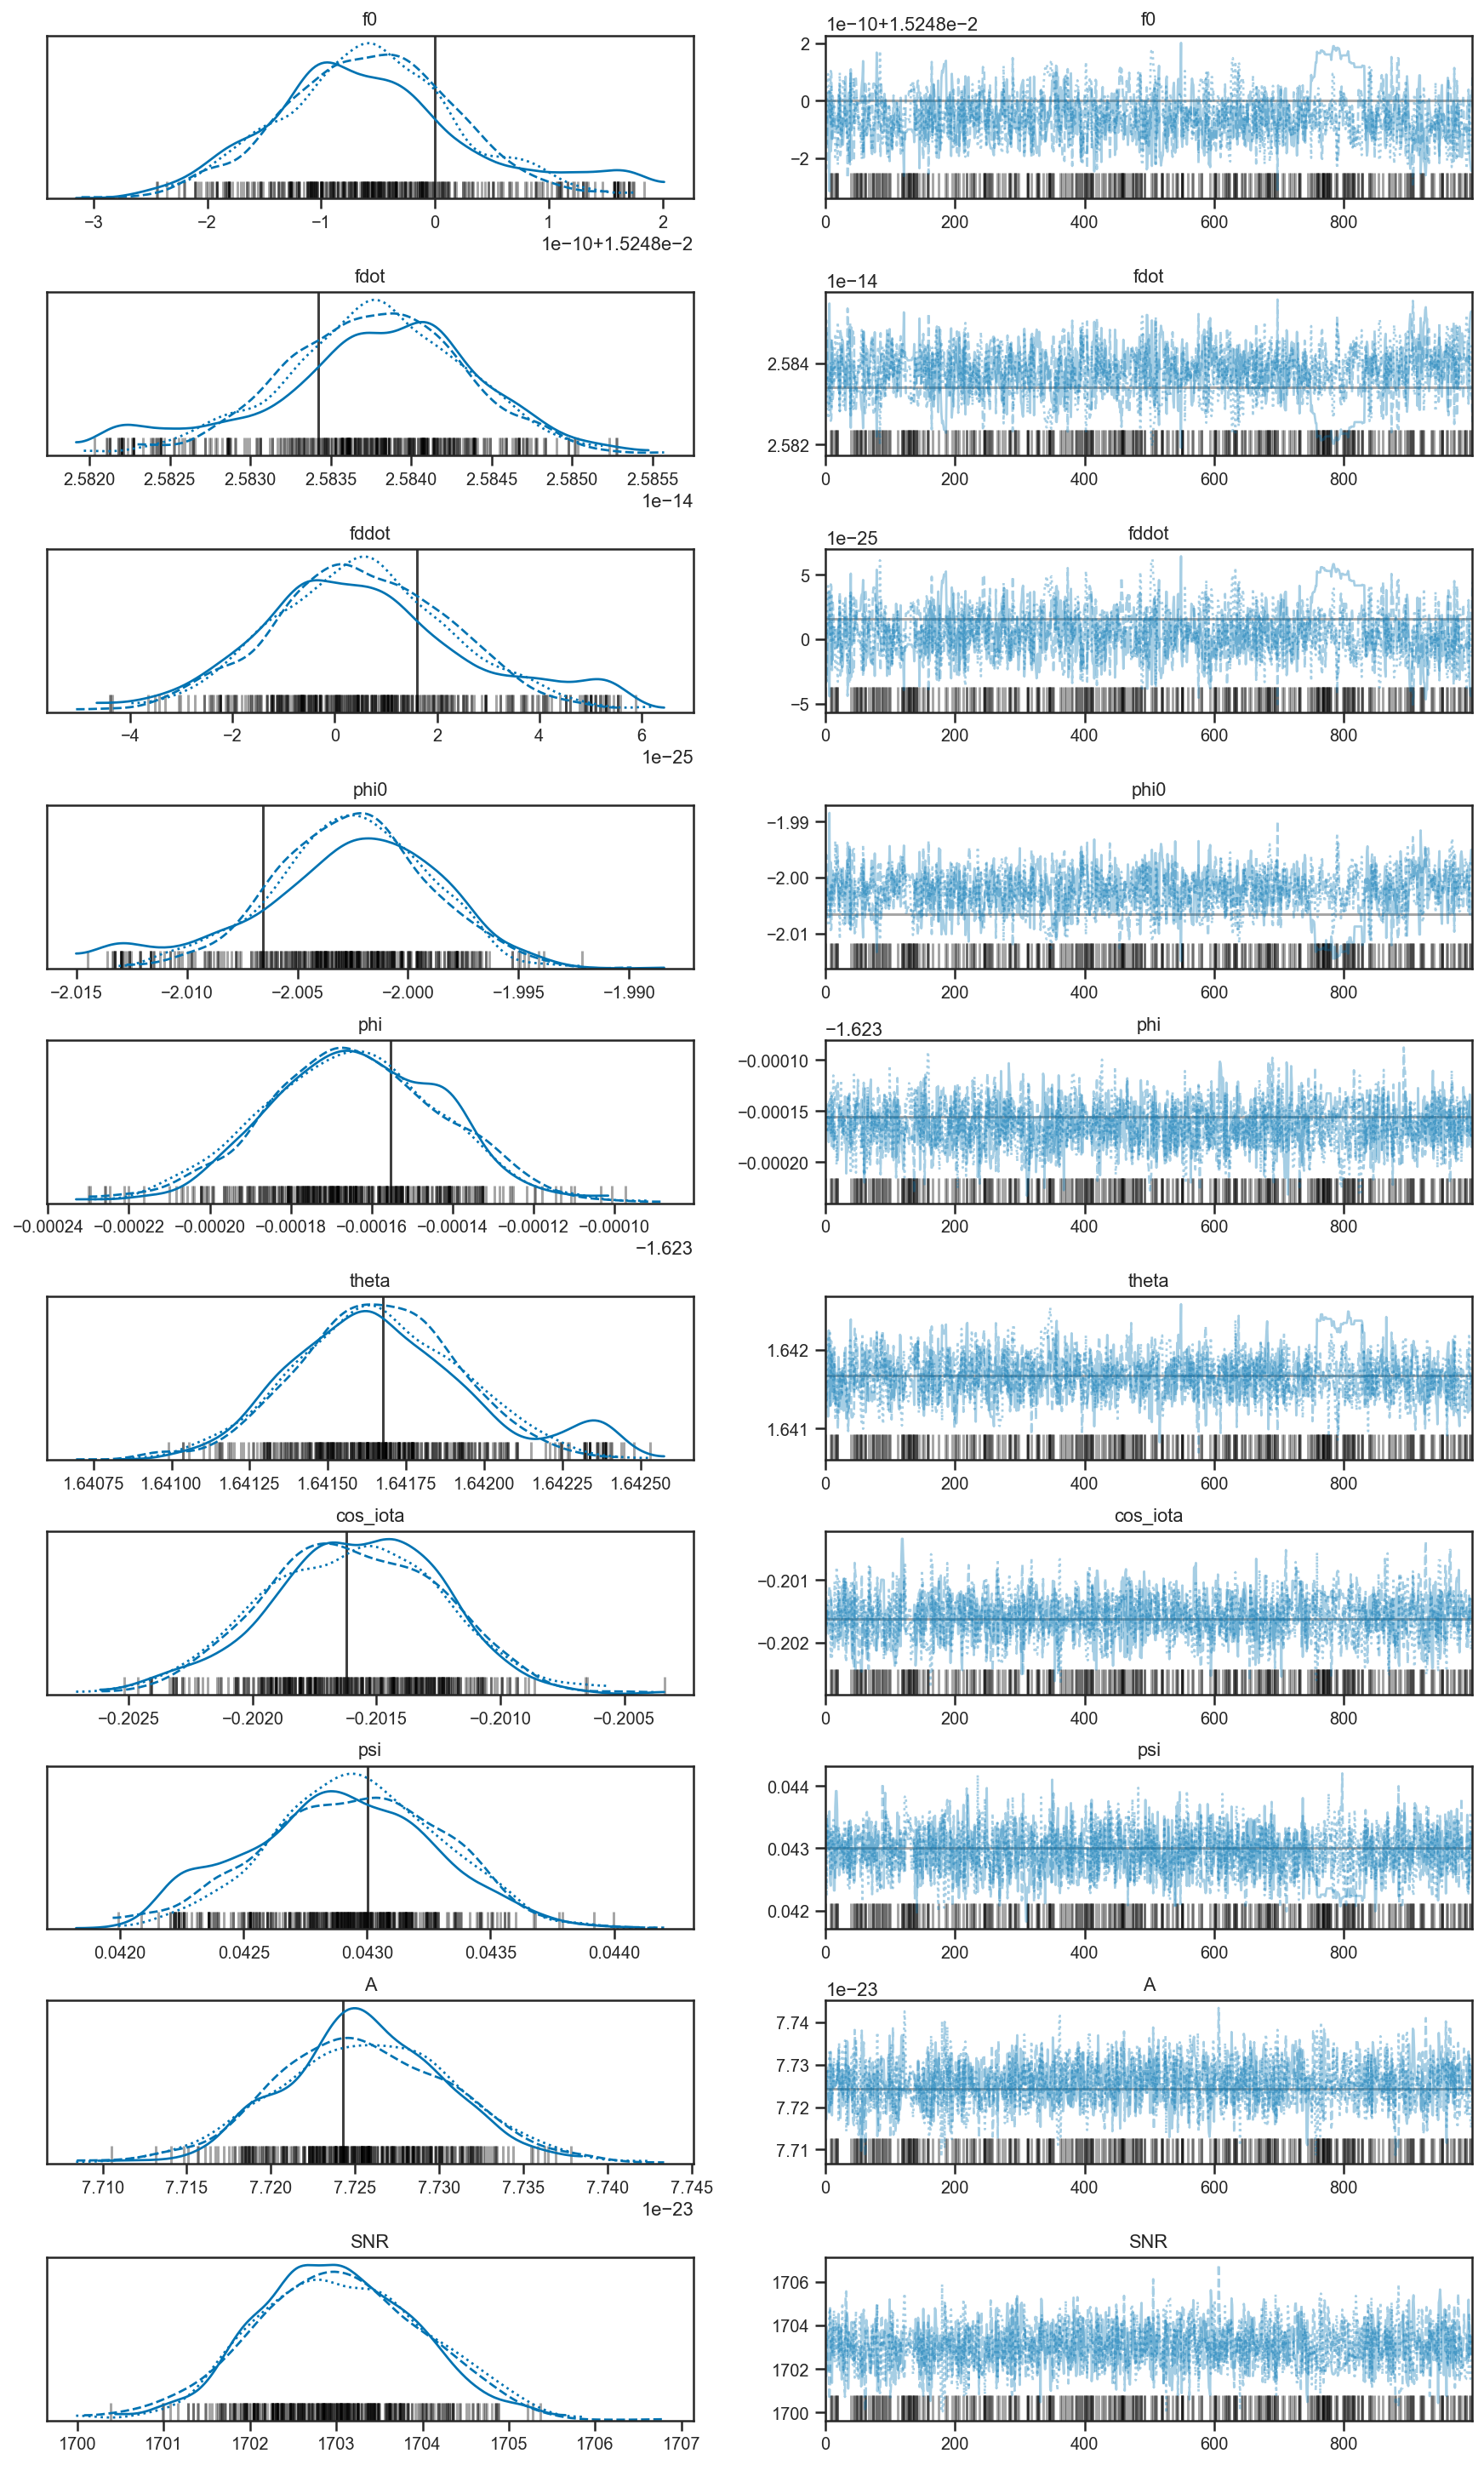

In [5]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    az.plot_trace(fit, compact=True, var_names=['f0', 'fdot', 'fddot', 'phi0', 'phi', 'theta', 'cos_iota', 'psi', 'A', 'SNR'],
                  lines=(('f0', {}, inj['f0']),
                         ('fdot', {}, inj['fdot']),
                         ('fddot', {}, inj['fddot']),
                         ('phi0', {}, inj['phi0']),
                         ('phi', {}, inj['phi']),
                         ('theta', {}, inj['theta']),
                         ('cos_iota', {}, inj['cos_iota']),
                         ('psi', {}, inj['psi']),
                         ('A', {}, inj['A'])),
                  coords={'chain': good_chains})

In [20]:
az.ess(fit, var_names=['A', 'phi0', 'f0', 'fdot', 'fddot', 'cos_iota', 'psi', 'theta', 'phi'])

<xarray.Dataset>
Dimensions:   ()
Data variables:
    A         float64 1.522e+03
    phi0      float64 240.8
    f0        float64 237.1
    fdot      float64 245.6
    fddot     float64 253.5
    cos_iota  float64 1.313e+03
    psi       float64 329.1
    theta     float64 279.3
    phi       float64 1.053e+03

In [21]:
az.rhat(fit, var_names=['A', 'phi0', 'f0', 'fdot', 'fddot', 'cos_iota', 'psi', 'theta', 'phi'])

<xarray.Dataset>
Dimensions:   ()
Data variables:
    A         float64 1.006
    phi0      float64 1.017
    f0        float64 1.016
    fdot      float64 1.011
    fddot     float64 1.009
    cos_iota  float64 1.003
    psi       float64 1.008
    theta     float64 1.007
    phi       float64 1.004

/Users/wfarr/Code/GBPyro/kde_contour.py:28: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  ax.contour(XS, YS, ZS, levels=l, **kwargs)


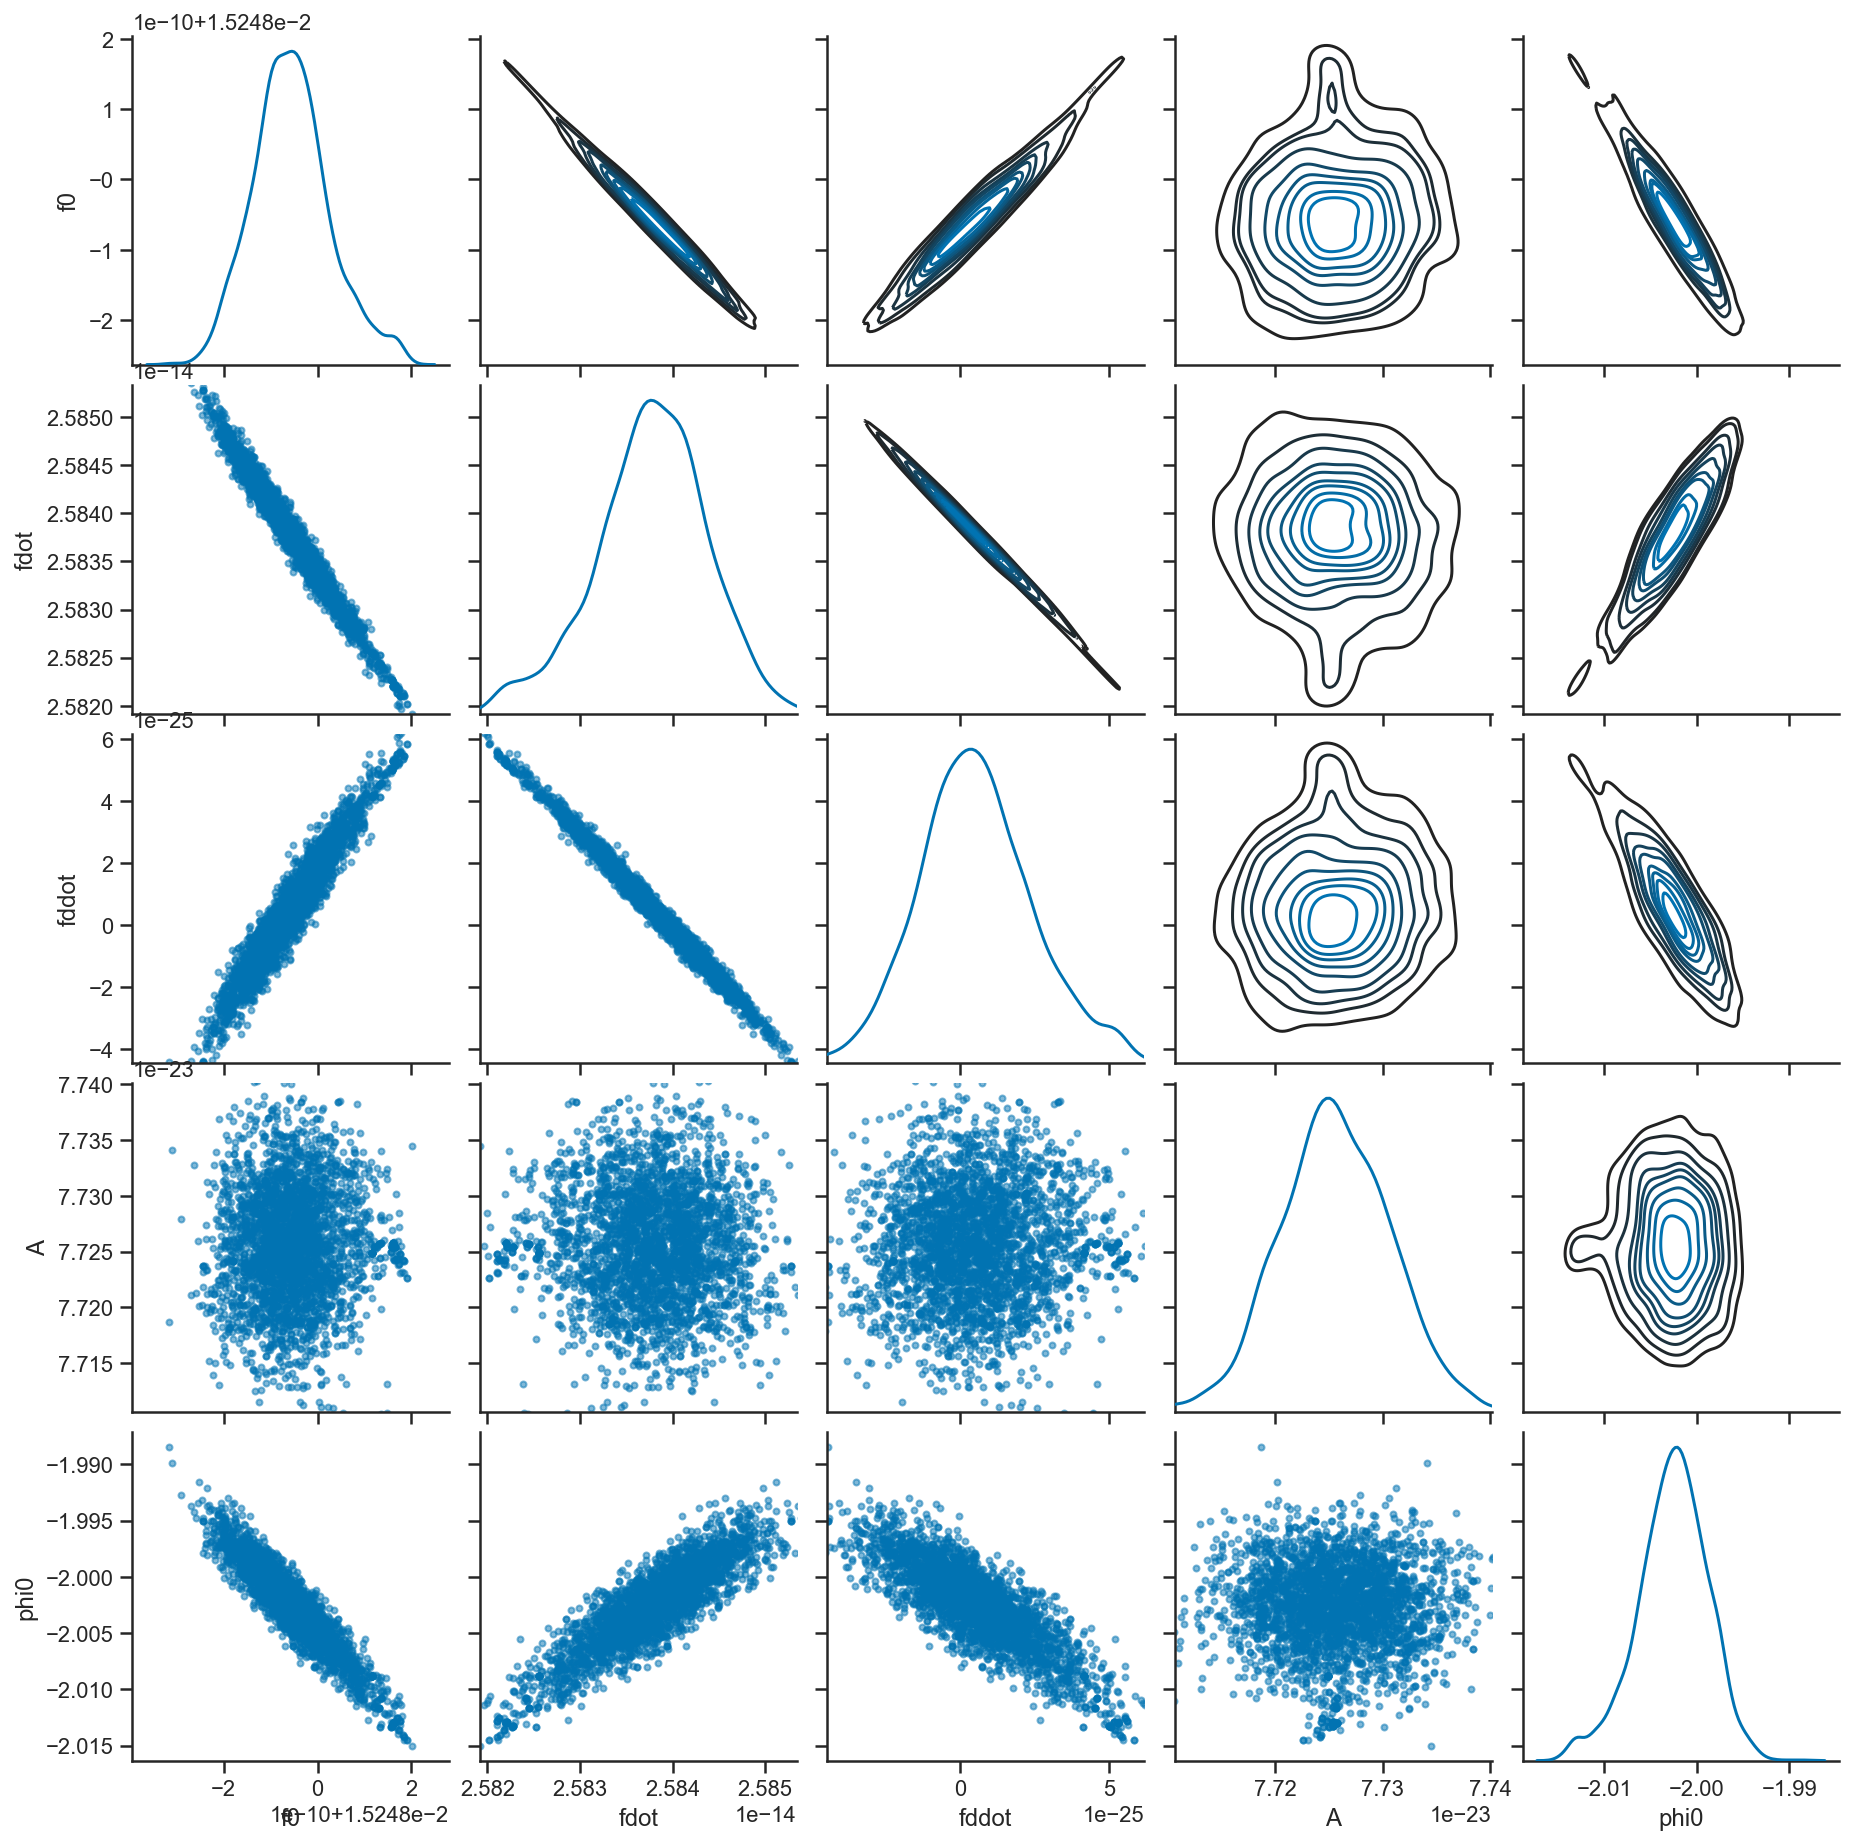

In [9]:
m = {}
for k in ['f0', 'fdot', 'fddot', 'A', 'phi0']:
    m[k] = fit.posterior[k].values[good_chains,:].flatten()
df = pd.DataFrame(m)
g = sns.PairGrid(df, diag_sharey=False)
g.map_diag(sns.kdeplot)
g.map_upper(kdeplot_2d_clevels)
g.map_lower(scatter, marker='.', alpha=0.5)

Or, more familiar, a corner plot:

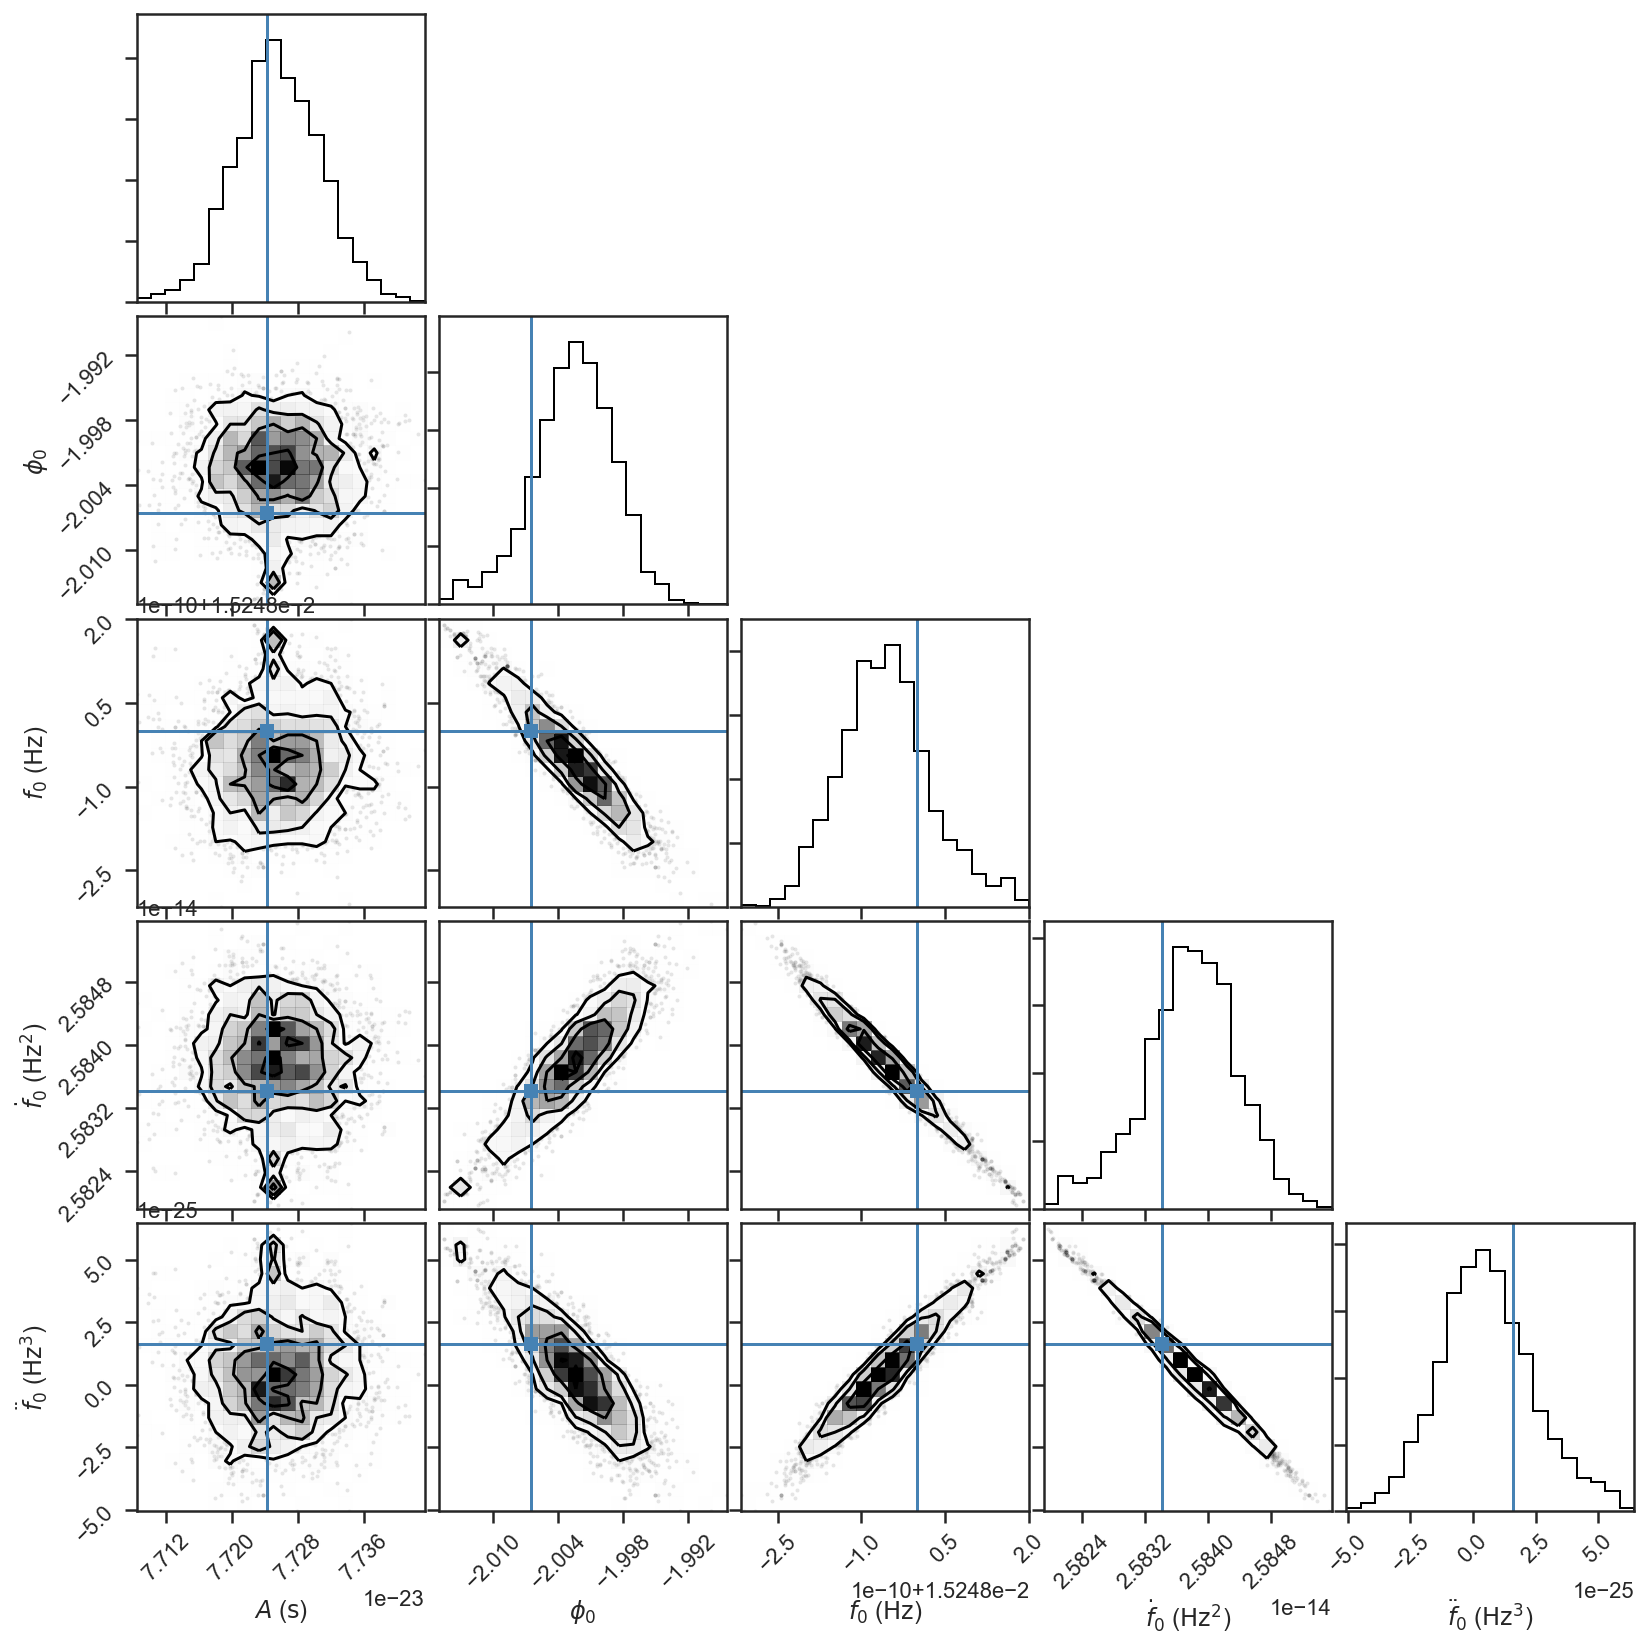

In [26]:
corner(column_stack([fit.posterior[k].values.flatten() for k in ['A', 'phi0', 'f0', 'fdot', 'fddot']]),
       labels=[r'$A$ ($\mathrm{s}$)', r'$\phi_0$', r'$f_0$ ($\mathrm{Hz}$)', r'$\dot{f}_0$ ($\mathrm{Hz}^2$)', r'$\ddot{f}_0$ ($\mathrm{Hz}^3$)'],
       truths=[inj['A'], inj['phi0'], inj['f0'], inj['fdot'], inj['fddot']]);

Here is a comparison between the model and the data, in the real part of the $A$ channel.  The residuals look reasonable by eye, but their distribution is not $N\left(0, \sigma_A\right)$, so there is still something left in the data that the model has not yet accessed.

In [10]:
N = fit.constant_data.A_re_data.shape[0]
t = inj['theta']
p = inj['phi']
nhat = array([cos(t)*sin(p), sin(t)*sin(p), cos(t)])
yf_re, yf_im = gbfit.y_fd(Tobs, inj['f0'], inj['fdot'], inj['fddot'], inj['phi0'], nhat, inj['cos_iota'], inj['psi'], hbin, N)
((X_re, X_im), (Y_re, Y_im), (Z_re, Z_im)) = gbfit.XYZ_freq(yf_re, yf_im, Tobs, hbin, N)
((A_re, A_im), (E_re, E_im), (_, _)) = gbfit.AET_XYZ(X_re, X_im, Y_re, Y_im, Z_re, Z_im)

A_true = A_re.eval()*inj['A']

Text(0.5, 0, '$f$ ($\\mathrm{Hz}$)')

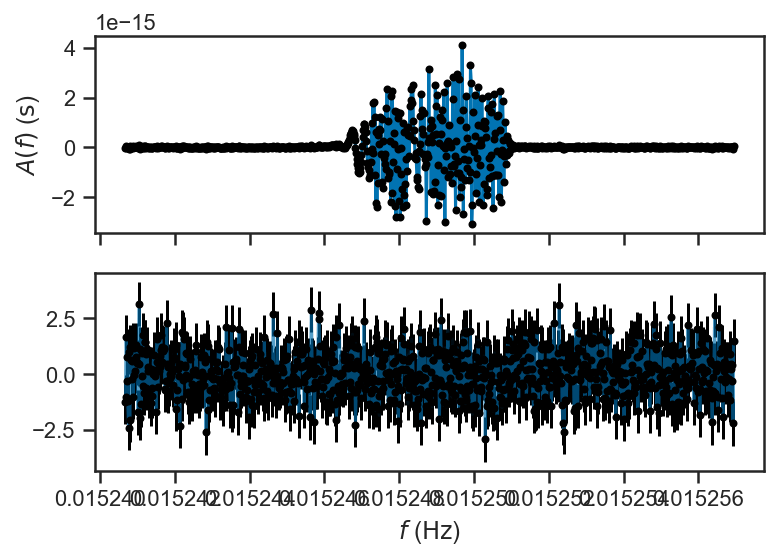

In [16]:
fig, (ax1, ax2) = subplots(nrows=2, ncols=1, sharex=True)

N = fit.constant_data.A_re_data.shape[0]//2 - 1
Ad = concatenate((fit.constant_data.A_re_data.values[-N:], fit.constant_data.A_re_data.values[:N+1]))
A = concatenate((fit.posterior.A_re.values[good_chains,:,-N:], fit.posterior.A_re.values[good_chains,:,:N+1]), axis=2)
sigma = sqrt(2*pi*1e7*gbfit.Sn(inj['f0'])/4)

fs = arange(-N, N+1)/Tobs + hbin/Tobs

l, = ax1.plot(fs, median(A, axis=(0,1)))
ax1.fill_between(fs, percentile(A, 84, axis=(0,1)), percentile(A, 16, axis=(0,1)), alpha=0.25, color=l.get_color())
ax1.fill_between(fs, percentile(A, 97.5, axis=(0,1)), percentile(A, 2.5, axis=(0,1)), alpha=0.25, color=l.get_color())

ax1.errorbar(fs, Ad, yerr=sigma, color='k', fmt='.')

ax2.errorbar(fs, (Ad-median(A, axis=(0,1)))/sigma, yerr=ones_like(Ad), fmt='.', color='k')
for i in range(10):
    j = randint(A.shape[0])
    k = randint(A.shape[1])
    plot(fs, (Ad-A[j,k,:])/sigma, color=l.get_color(), alpha=0.1)

ax1.set_ylabel(r'$A(f)$ ($\mathrm{s}$)')
ax2.set_xlabel(r'$f$ ($\mathrm{Hz}$)')

In [17]:
rs = []
for i in good_chains:
    for j in range(fit.posterior.A_re.shape[1]):
        rs.append((Ad - A[i,j,:])/sigma)
rs = array(rs)
A2s = array([ss.anderson(r).statistic for r in rs])
ares = ss.anderson(rs[0])
A2_95 = ares.critical_values[argmin(abs(ares.significance_level - 5.0))]

Text(0.5, 0, '$A^2$')

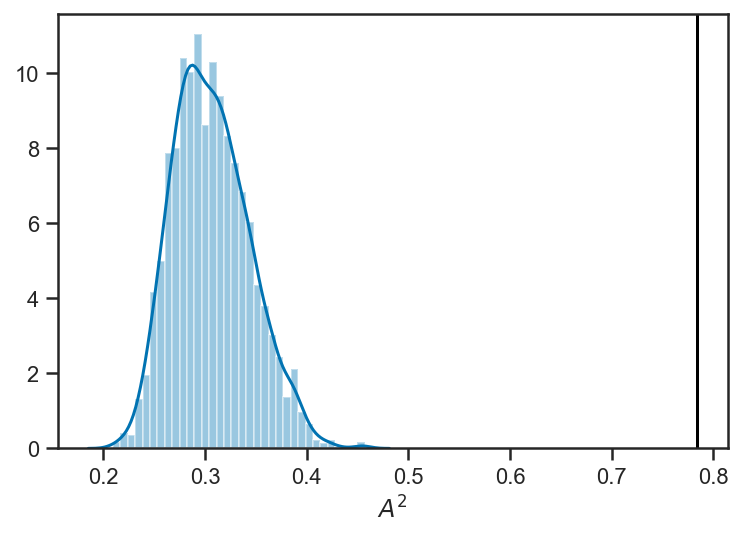

In [18]:
sns.distplot(A2s)
axvline(A2_95, color='k') # 95% CI
xlabel(r'$A^2$')

Text(0, 0.5, '$\\theta$ ($\\mathrm{deg}$)')

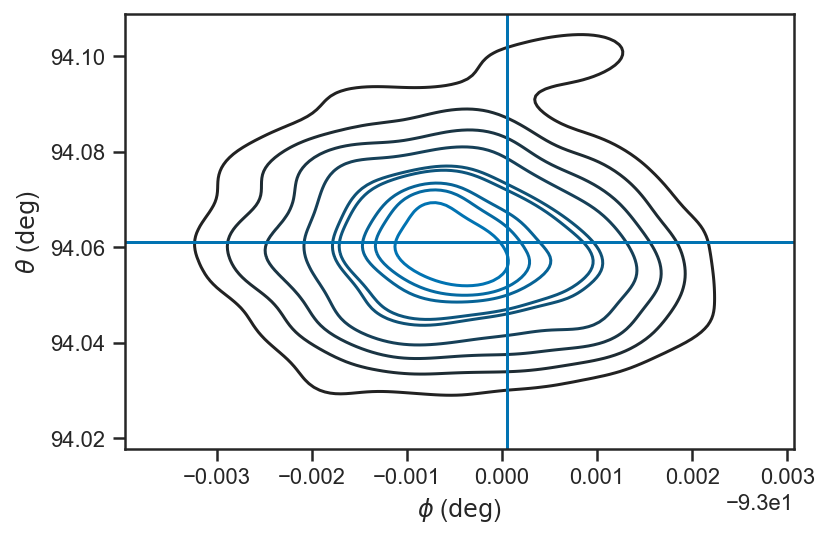

In [8]:
kdeplot_2d_clevels(fit.posterior.phi[good_chains,:].values.flatten()*180/pi,
                   fit.posterior.theta[good_chains,:].values.flatten()*180/pi)
axhline(inj['theta']*180/pi)
axvline(inj['phi']*180/pi)

xlabel(r'$\phi$ ($\mathrm{deg}$)')
ylabel(r'$\theta$ ($\mathrm{deg}$)')

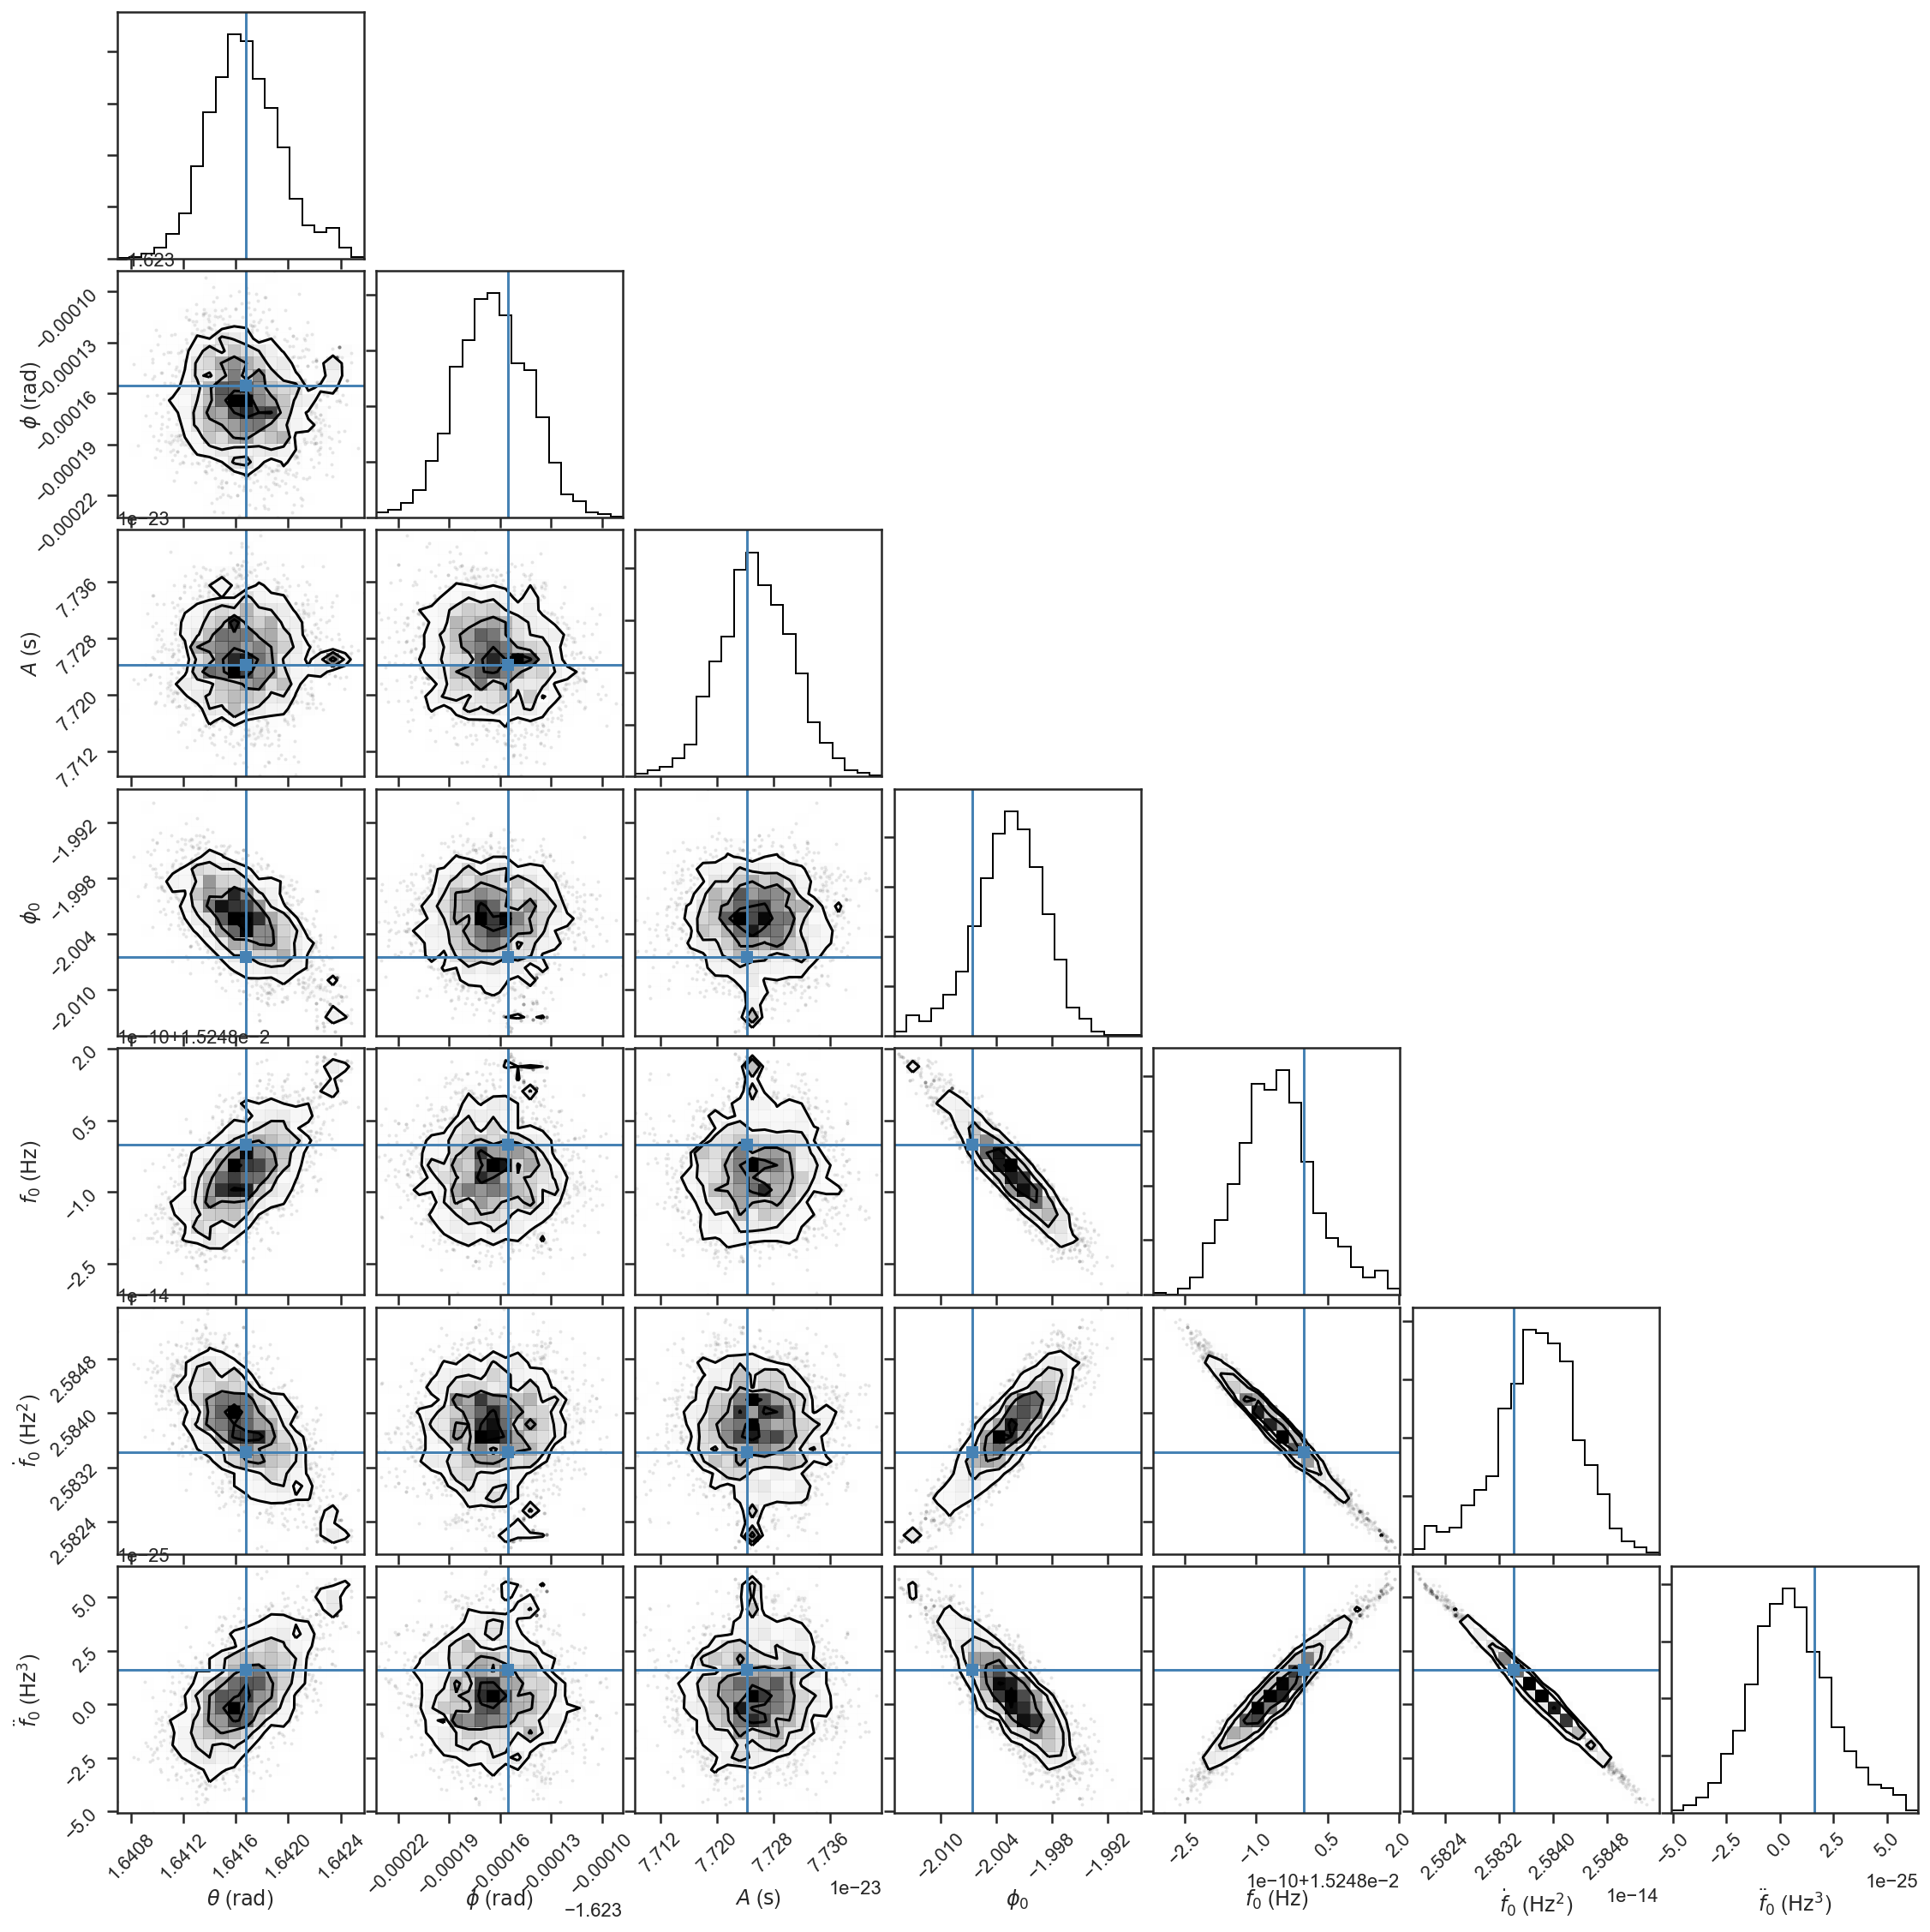

In [28]:
corner(column_stack([fit.posterior[k].values.flatten() for k in ['theta', 'phi', 'A', 'phi0', 'f0', 'fdot', 'fddot']]),
       labels=[r'$\theta$ ($\mathrm{rad}$)', r'$\phi$ ($\mathrm{rad}$)', r'$A$ ($\mathrm{s}$)', r'$\phi_0$', r'$f_0$ ($\mathrm{Hz}$)', r'$\dot{f}_0$ ($\mathrm{Hz}^2$)', r'$\ddot{f}_0$ ($\mathrm{Hz}^3$)'],
       truths=[inj['theta'], inj['phi'], inj['A'], inj['phi0'], inj['f0'], inj['fdot'], inj['fddot']]);